In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from sklearn.metrics import r2_score

In [23]:
# Function to clean and ensure "Price" is numeric and drop irrelevant columns
def clean_data(df):
    # Drop the "MA 30 90" columns
    df = df.drop(columns=['MA 30 90'], errors='ignore')
    # Convert "Price" column to numeric, coerce errors to NaN
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    # Drop any rows with missing or invalid "Price" values
    df = df.dropna(subset=['Price'])
    return df

# Load data from new processed files
aapl_data = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\AAPL_Processed.csv', parse_dates=['Date'], index_col='Date')
acb_data = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\ACB_Processed.csv', parse_dates=['Date'], index_col='Date')
bid_data = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\BID_Processed.csv', parse_dates=['Date'], index_col='Date')
fpt_data = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\FPT_Processed.csv', parse_dates=['Date'], index_col='Date')
googl_data = pd.read_csv('D:\\Github anyud\\final\\Data_stock\\GOOGL_Processed.csv', parse_dates=['Date'], index_col='Date')

# Clean the data by dropping "MA 30 90" columns and ensuring numeric "Price"
aapl_data = clean_data(aapl_data)
acb_data = clean_data(acb_data)
bid_data = clean_data(bid_data)
fpt_data = clean_data(fpt_data)
googl_data = clean_data(googl_data)

# Ensure the data is sorted by date
aapl_data.sort_index(inplace=True)
acb_data.sort_index(inplace=True)
bid_data.sort_index(inplace=True)
fpt_data.sort_index(inplace=True)
googl_data.sort_index(inplace=True)

# Split data into training and testing sets
def split_data(data, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train_arima = data.iloc[:train_size]
    test_arima = data.iloc[train_size:]
    return train_arima, test_arima

train_aapl_arima, test_aapl_arima = split_data(aapl_data)
train_acb_arima, test_acb_arima = split_data(acb_data)
train_bid_arima, test_bid_arima = split_data(bid_data)
train_fpt_arima, test_fpt_arima = split_data(fpt_data)
train_googl_arima, test_googl_arima = split_data(googl_data)

# ARIMA parameters for each stock
arima_params = {
    'AAPL': (1, 1, 0),
    'ACB': (1, 1, 1),
    'BID': (1, 1, 0),
    'FPT': (1, 1, 0),
    'GOOGL': (1, 1, 0)
}

# Function to perform walk-forward validation
def walk_forward_arima(train, test, order):
    history = [x for x in train['Price']]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test['Price'].iloc[t]
        history.append(obs)
    return predictions

# Perform walk-forward validation for each stock
pred_aapl_arima = walk_forward_arima(train_aapl_arima, test_aapl_arima, arima_params['AAPL'])
pred_acb_arima = walk_forward_arima(train_acb_arima, test_acb_arima, arima_params['ACB'])
pred_bid_arima = walk_forward_arima(train_bid_arima, test_bid_arima, arima_params['BID'])
pred_fpt_arima = walk_forward_arima(train_fpt_arima, test_fpt_arima, arima_params['FPT'])
pred_googl_arima = walk_forward_arima(train_googl_arima, test_googl_arima, arima_params['GOOGL'])

# Convert predictions to Pandas Series for easier evaluation and comparison
pred_aapl_arima = pd.Series(pred_aapl_arima, index=test_aapl_arima.index)
pred_acb_arima = pd.Series(pred_acb_arima, index=test_acb_arima.index)
pred_bid_arima = pd.Series(pred_bid_arima, index=test_bid_arima.index)
pred_fpt_arima = pd.Series(pred_fpt_arima, index=test_fpt_arima.index)
pred_googl_arima = pd.Series(pred_googl_arima, index=test_googl_arima.index)

# Evaluation function to calculate metrics
def evaluate_predictions(actual, pred, stock_name):
    actual, pred = actual.align(pred, join='inner')
    r2 = r2_score(actual, pred)
    mse = mean_squared_error(actual, pred)
    mape = mean_absolute_percentage_error(actual, pred)
    rmse = np.sqrt(mse)
    accuracy_threshold = 0.05  # Accuracy threshold within 5%
    accuracy = np.mean(np.abs((actual - pred) / actual) < accuracy_threshold)
    print(f'{stock_name} - R²: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, Accuracy: {accuracy:.4f}')

# Evaluate predictions for each stock
evaluate_predictions(test_aapl_arima['Price'], pred_aapl_arima, 'AAPL')
evaluate_predictions(test_acb_arima['Price'], pred_acb_arima, 'ACB')
evaluate_predictions(test_bid_arima['Price'], pred_bid_arima, 'BID')
evaluate_predictions(test_fpt_arima['Price'], pred_fpt_arima, 'FPT')
evaluate_predictions(test_googl_arima['Price'], pred_googl_arima, 'GOOGL')


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AAPL - R²: 0.9864, MSE: 8.1106, RMSE: 2.8479, MAPE: 0.0123, Accuracy: 0.9857
ACB - R²: 0.9677, MSE: 0.4012, RMSE: 0.6334, MAPE: 0.0409, Accuracy: 0.7207
BID - R²: 0.9843, MSE: 590428.7822, RMSE: 768.3936, MAPE: 0.0137, Accuracy: 0.9607
FPT - R²: 0.9957, MSE: 2637829.2486, RMSE: 1624.1395, MAPE: 0.0111, Accuracy: 0.9897
GOOGL - R²: 0.9897, MSE: 7.8389, RMSE: 2.7998, MAPE: 0.0166, Accuracy: 0.9529


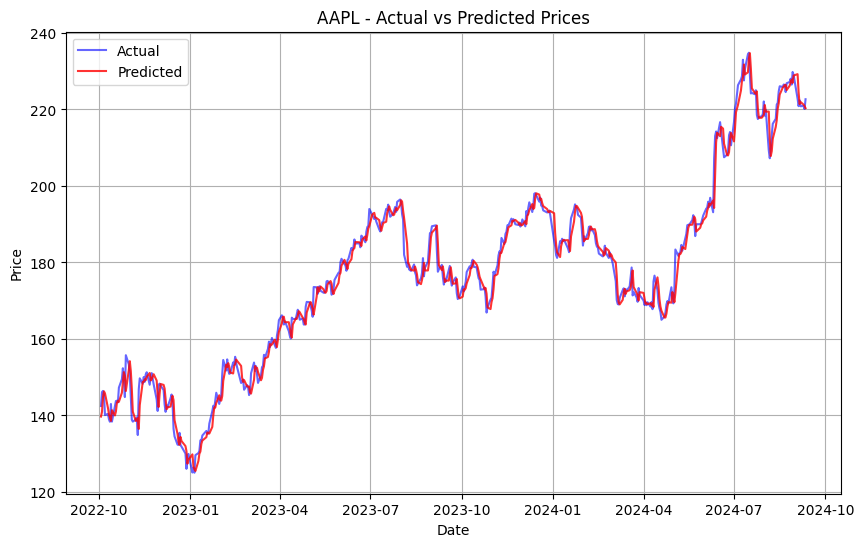

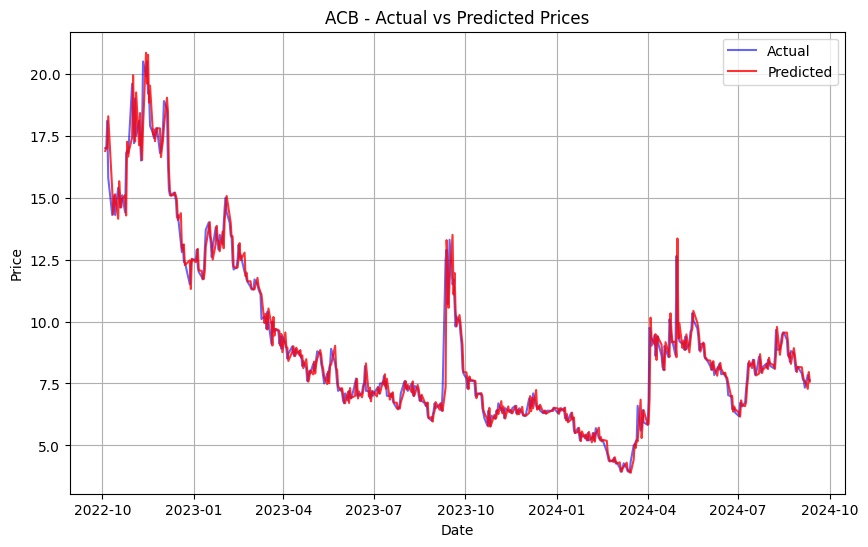

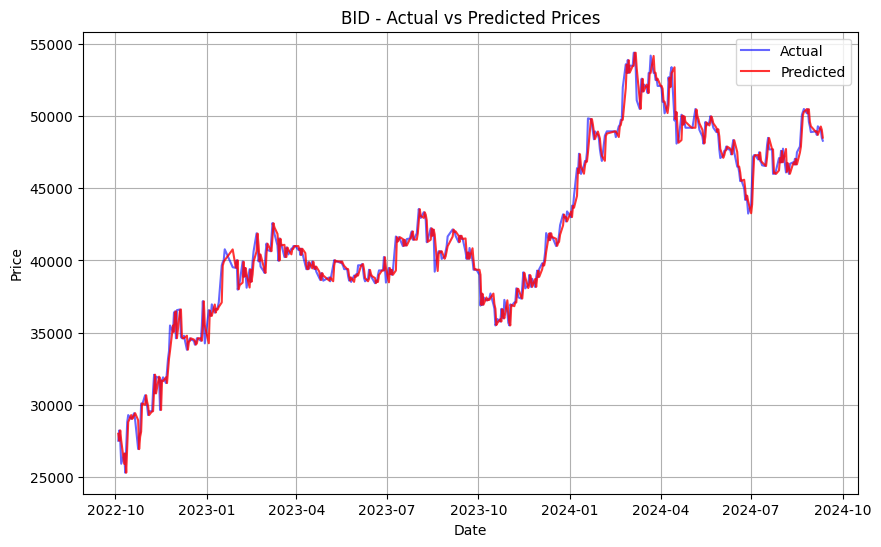

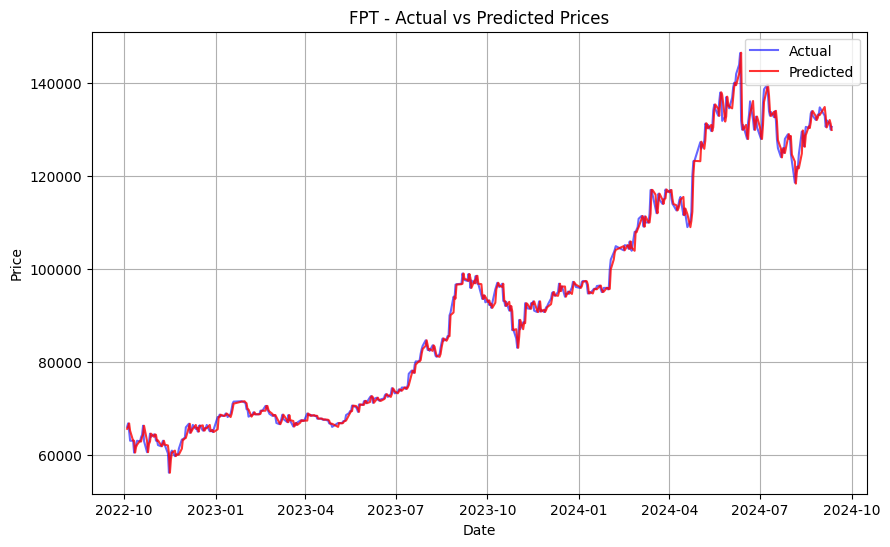

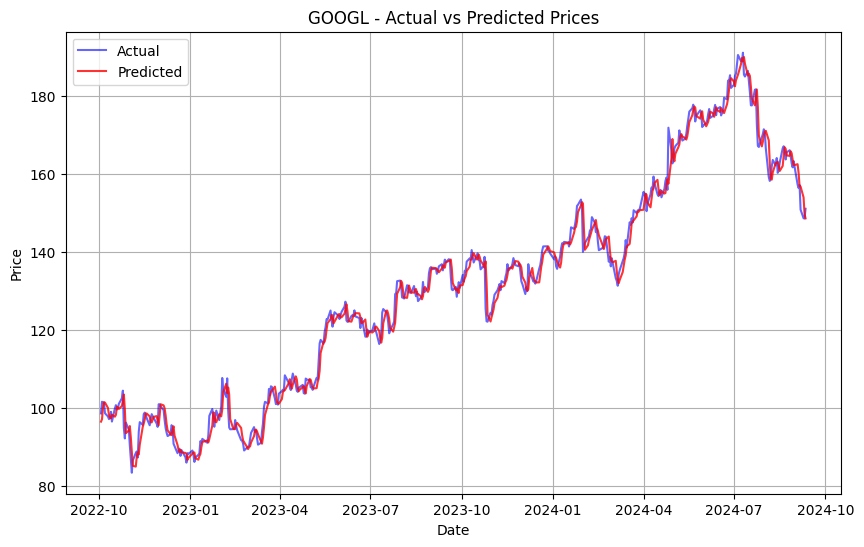

In [25]:
import matplotlib.pyplot as plt

# Function to plot actual vs predicted values with solid lines
def plot_predictions(actual, predicted, stock_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', color='blue', alpha=0.6)
    plt.plot(predicted.index, predicted, label='Predicted', color='red', alpha=0.8)
    plt.title(f'{stock_name} - Actual vs Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for AAPL
plot_predictions(test_aapl_arima['Price'], pred_aapl_arima, 'AAPL')

# Plot for ACB
plot_predictions(test_acb_arima['Price'], pred_acb_arima, 'ACB')

# Plot for BID
plot_predictions(test_bid_arima['Price'], pred_bid_arima, 'BID')

# Plot for FPT
plot_predictions(test_fpt_arima['Price'], pred_fpt_arima, 'FPT')

# Plot for GOOGL
plot_predictions(test_googl_arima['Price'], pred_googl_arima, 'GOOGL')
